# General presentation
## Machine Learning : Wine Classification using others algorithms                           
    Auteur : Thierry SANDOZ and Stephen MONNET                        
    Date : 10.06.2020           
    Contenu : Essai de classification des différents vins blancs en utilisant d'autres algorithms

## Imported librairies and configurations

In [1]:
## Global import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import seaborn as sns

from sys import path
path.append('functions')
from WineClassificationLib import visualize_classification_performance
from WineClassificationLib import train_predict_evaluate

## Data separation 
from sklearn.model_selection import train_test_split

## Normalization 
from sklearn import preprocessing

## learning curve
from sklearn.model_selection import learning_curve

## Supervised learning classification models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Statistiques
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer 

## Ouverture des fichiers + Prétraitement des données
Les données sont enregistrées en format csv et celles-ci sont séparées par des ';'. La fonction read_csv de Pandas permet directement d'ouvrir un fichier et de stocker les différentes données sous forme de tableau. Le tableau présent ci-dessous permet de visualiser un aperçu du contenu des ces données. Le prétraitement des données est détaillé dans le fichier WineClassification.ipynb

In [2]:
dataWine = pd.read_csv("data/winequality-white.csv", sep=';')

## Affichage des 5 premières lignes de données
display(dataWine.head(n=5))

## Affichage du nombre de données
nb_data = len(dataWine)
print('Le nombre de données présentes dans le fichier (taille du dataset) est de :', nb_data)

## Séparation des données en différentes classes : 1, 2, 3, 4 = mauvais, 5 = assez bon, 6 = bon, 7 = très bon, 8, 9, 10 => excellent
bins = [3,4,5,6,7,9]
quality_labels=[0,1,2,3,4]
num_labels = len(quality_labels) ## Number of labels
dataWine['quality_categorical'] = pd.cut(dataWine['quality'], bins=bins, labels=quality_labels, include_lowest=True)

# For each feature find the data points with extreme high or low values
outliers = []
features_raw = dataWine.drop(['quality', 'quality_categorical'], axis = 1)
quality_raw = dataWine['quality_categorical']

for feature in features_raw.keys():

    Q1 = np.percentile(features_raw[feature], q=25)

    Q3 = np.percentile(features_raw[feature], q=75)
    
    interquartile_range = Q3 - Q1
    step = 1.5 * interquartile_range
    
    #print("Data points considered outliers for the feature '{}':".format(feature))
    #display(dataWine[~((dataWine[feature] >= Q1 - step) & (dataWine[feature] <= Q3 + step))])

    outliers = outliers + list(features_raw[~((features_raw[feature] >= Q1 - step) & (features_raw[feature] <= Q3 + step))].index)
    
    # Remove the outliers, if any were specified
    good_data = features_raw.drop(features_raw.index[outliers]).reset_index(drop = True)
    good_quality = quality_raw.drop(quality_raw.index[outliers]).reset_index(drop = True)
    
print("Nb data before removing the outliers :", len(dataWine))
print("Nb data after removing the outliers :", len(good_data))

## Normalize the features between 0 and 1
x = good_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
good_data = pd.DataFrame(x_scaled, columns=good_data.columns)

## Diplay the first five row of the datas
display(good_data.head(n=5))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Le nombre de données présentes dans le fichier (taille du dataset) est de : 4898
Nb data before removing the outliers : 4898
Nb data after removing the outliers : 4011


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.550,0.469136,0.553191,0.939252,0.527273,0.551282,0.636752,0.935354,0.232877,0.425926,0.068966
1,0.375,0.543210,0.510638,0.046729,0.600000,0.153846,0.474359,0.463973,0.643836,0.500000,0.189655
2,0.825,0.493827,0.638298,0.294393,0.618182,0.358974,0.324786,0.538047,0.589041,0.407407,0.293103
3,0.600,0.370370,0.468085,0.369159,0.763636,0.576923,0.705128,0.571717,0.493151,0.333333,0.258621
4,0.600,0.370370,0.468085,0.369159,0.763636,0.576923,0.705128,0.571717,0.493151,0.333333,0.258621


### Séparation des données en 2 sets
Pour déterminer si les résultats obtenus par l'algorithme sont bons, il est important de séparer les données en 2 sets de données. Le premier est le set d'entraînement. Il représente 80% du set complet et est celui qui permet d'entraîner l'algorithme de ML. Le deuxième est un set de test qui permettra d'observer les résultats obtenus sur des données n'ayant pas été utilisée pour l'entraînement. Celui-ci représente 20% du set complet. La fonction "train_test_split" de sklearn permet de réaliser cette division en 2 sets de manière aléatoire. Dans celle-ci on peut spécifier la taille du test set.

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(good_data, 
                                                    good_quality, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 3208 samples.
Testing set has 803 samples.


### Test des différents algorithms de classification
Dans cette partie, on teste de nombreux algorithms de classification de manière à pouvoir déterminer lequel est le plus adapté au problème

In [4]:
# Initialize the models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(max_depth=None, random_state=None)
clf_C = RandomForestClassifier(max_depth=None, random_state=None)
clf_D = LogisticRegression()
clf_E = KNeighborsClassifier(n_neighbors=5)
clf_F = SVC(kernel="linear")
clf_I = MLPClassifier(hidden_layer_sizes=(11,2),solver='sgd',learning_rate_init=0.01,max_iter=1000)
clf_J = AdaBoostClassifier()
clf_K = GradientBoostingClassifier()

In [5]:
# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train)*10/100)
samples_1 = int(len(y_train)*1/100)

In [6]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_I, clf_J, clf_K]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict_evaluate(clf, samples, X_train, y_train, X_test, y_test)

GaussianNB trained on 32 samples.
GaussianNB trained on 320 samples.
GaussianNB trained on 3208 samples.
DecisionTreeClassifier trained on 32 samples.
DecisionTreeClassifier trained on 320 samples.
DecisionTreeClassifier trained on 3208 samples.
RandomForestClassifier trained on 32 samples.
RandomForestClassifier trained on 320 samples.
RandomForestClassifier trained on 3208 samples.
LogisticRegression trained on 32 samples.
LogisticRegression trained on 320 samples.


c:\users\thierry\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression trained on 3208 samples.
KNeighborsClassifier trained on 32 samples.
KNeighborsClassifier trained on 320 samples.
KNeighborsClassifier trained on 3208 samples.
SVC trained on 32 samples.
SVC trained on 320 samples.
SVC trained on 3208 samples.
MLPClassifier trained on 32 samples.
MLPClassifier trained on 320 samples.
MLPClassifier trained on 3208 samples.
AdaBoostClassifier trained on 32 samples.
AdaBoostClassifier trained on 320 samples.
AdaBoostClassifier trained on 3208 samples.
GradientBoostingClassifier trained on 32 samples.
GradientBoostingClassifier trained on 320 samples.
GradientBoostingClassifier trained on 3208 samples.


### Visualisation de la performance de chacun des algorithms
Pour visualiser la performance de chacun des algorithms, on affiche un graphique comprenant les résultats obtenus pour chacun des algorithms. L'algorithme ayant obtenu le meilleur résultat est : "RandomForrestClassifier"

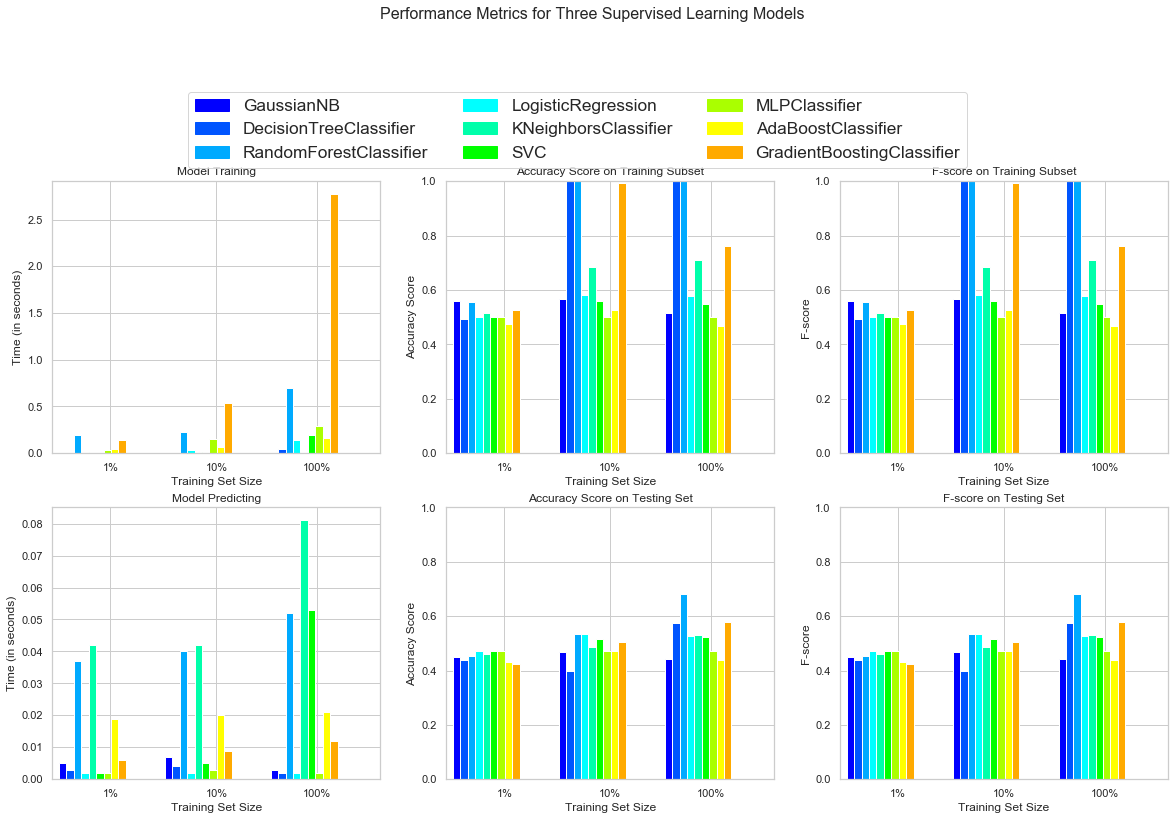

In [7]:
visualize_classification_performance(results)

### Optimisation de l'algorithme Random Forrest Classifier
Cette partie permet d'optimiser les paramètres de l'algorithme Random Forrest Classifier

In [8]:
clf = RandomForestClassifier()
        
parameters = {'n_estimators': [10, 20, 30], 'max_features':[3,4,5, None], 'max_depth': [5,6,7, None]} 

scorer = make_scorer(fbeta_score, beta=0.5, average="micro") 
grid_obj = GridSearchCV(clf, parameters, scoring=scorer) 
grid_fit = grid_obj.fit(X_train, y_train) 
 
# Get the estimator 
best_clf = grid_fit.best_estimator_ 
 
# Make predictions using the unoptimized and model 
predictions = (clf.fit(X_train, y_train)).predict(X_test) 
best_predictions = best_clf.predict(X_test) 
 
# Report the before-and-afterscores 
print("Unoptimized model\n------") 
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))) 
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5, average="micro"))) 
print("\nOptimized Model\n------") 
print(best_clf) 
print("\nFinal accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))) 
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5,  average="micro")))

Unoptimized model
------
Accuracy score on testing data: 0.6687
F-score on testing data: 0.6687

Optimized Model
------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Final accuracy score on the testing data: 0.6550
Final F-score on the testing data: 0.6550


### Visualisation des résultats
Ce paragraphe permet de visualiser les résultats obtenus à l'aide de l'algorithme random forrest classifier optimisé

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


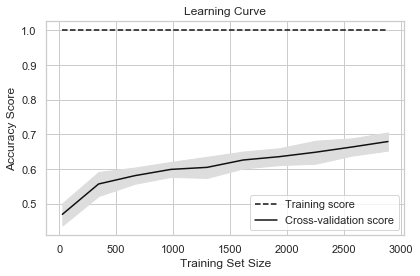

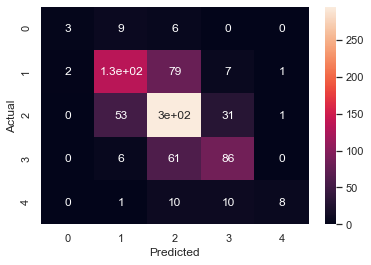

In [9]:
rf = RandomForestClassifier()

from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(max_depth=None, random_state=None), 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Plot the confusion matrix
confusion_matrix = pd.crosstab(y_test, best_predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

plt.show()

# 